In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import zlib
import numpy as np
import base64

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
df1 = pd.read_csv("Frame Selection/dataset.csv")
df2 = pd.read_csv("imagefeedback.csv", delimiter=";")
merged = pd.merge(df1, df2, left_on='image_id', right_on='IMAGE_ID', how='inner')
df = merged[['image_id', 'segmentation', 'SIDE']]
df = df.drop_duplicates()
df = df.dropna(subset=['SIDE'])

In [3]:
df['segmentation'] = df['segmentation'].apply(lambda x: base64.b64decode(x))
df['segmentation'] = df['segmentation'].apply(lambda x: zlib.decompress(x))
df['segmentation'] = df['segmentation'][df['segmentation'].apply(len) == 262144] # niektore elementy mialy inny rozmiar i cos mi nie dzialalo wiec usuwam

In [4]:
def mask_to_binary(mask_data, height=512, width=512):
    mask = np.frombuffer(mask_data, dtype=np.uint8).reshape(height, width)
    
    _, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)    
    return binary_mask

In [5]:
df['segmentation'].apply(type).value_counts()

segmentation
<class 'bytes'>    890
<class 'float'>     17
Name: count, dtype: int64

In [6]:
df = df[df['segmentation'].apply(lambda x: isinstance(x, bytes))]

In [7]:
df.loc[:, 'segmentation'] = df['segmentation'].apply(mask_to_binary)
df = df.reset_index(drop=True)

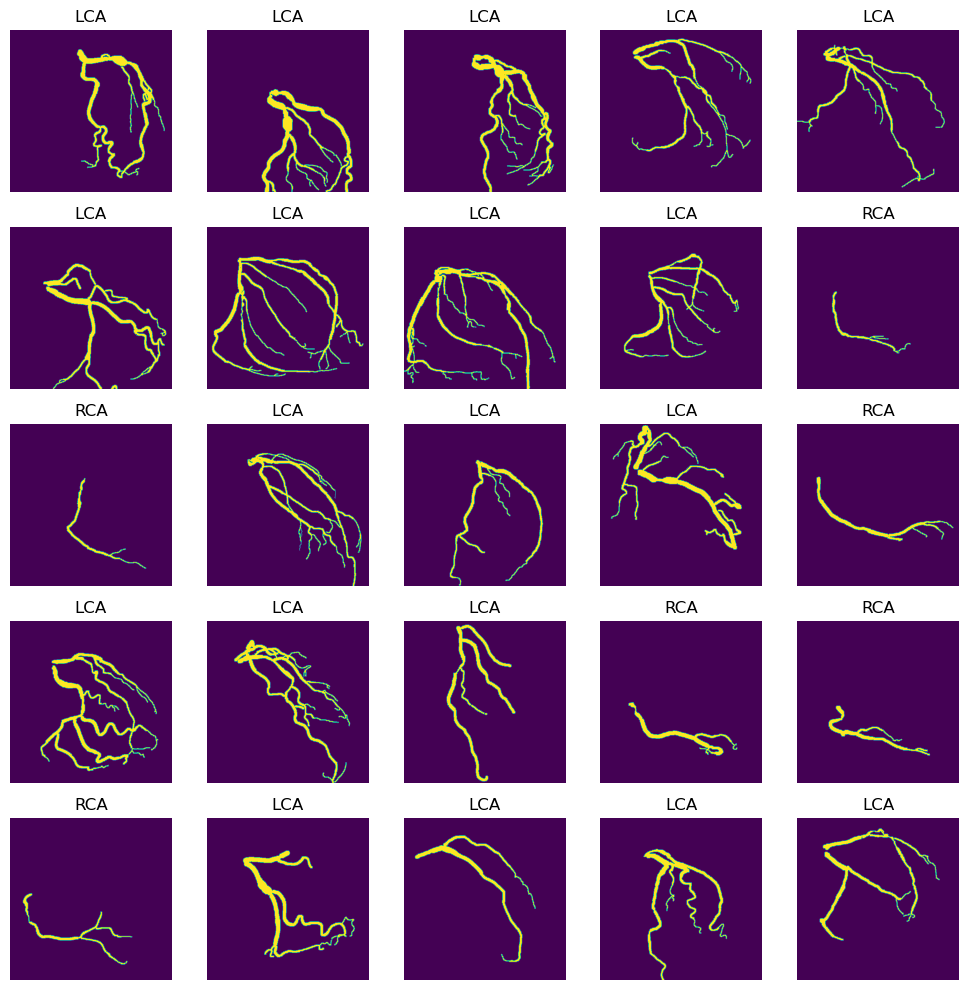

In [8]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(df.loc[i, 'segmentation'])
    plt.axis('off')
    title = "RCA" if df.loc[i, 'SIDE'] == 1.0 else "LCA"
    plt.title(title)

plt.tight_layout()
plt.show()

In [9]:
count_1_0 = df['SIDE'].value_counts().get(1.0, 0)
count_0_0 = df['SIDE'].value_counts().get(0.0, 0)
print("RCA count: ", count_1_0)
print("LCA count: ", count_0_0)

RCA count:  331
LCA count:  559


In [10]:
from torchvision import models
from torchvision.models import ResNet18_Weights

def get_model():
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False

    for param in model.layer4.parameters():
        param.requires_grad = True

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, loss_fn, optimizer = get_model()
model.to(device)
print("")

In [12]:
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA device count: {torch.cuda.device_count()}')
    print(f'CUDA device name: {torch.cuda.get_device_name(0)}')

CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [13]:
print(f"Used device: {device}")

Used device: cuda


In [14]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Dekodowanie maski binarnej z kolumny "segmentation"
        img_bytes = self.dataframe.iloc[idx]['segmentation']
        # image = Image.open(io.BytesIO(img_bytes)).convert("L")  # "L" oznacza skala szarości
        img_array = np.frombuffer(img_bytes, dtype=np.uint8)
        image = Image.fromarray(img_array).convert("L")
        label = self.dataframe.iloc[idx]['SIDE']
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

# Transformacje danych
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalizacja dla obrazów jednokanałowych
])

# Podział na zbiory treningowy i testowy
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['SIDE'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['SIDE'], random_state=42)

train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
        
        # Walidacja modelu
        val_loss = 0.0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).unsqueeze(1)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        val_loss = val_loss / len(val_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
        model.train()

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

In [18]:
train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)

Epoch 1/10, Training Loss: 0.2258
Epoch 1/10, Validation Loss: 0.9086, Validation Accuracy: 64.91%
Epoch 2/10, Training Loss: 0.0875
Epoch 2/10, Validation Loss: 2.5777, Validation Accuracy: 63.16%
Epoch 3/10, Training Loss: 0.1174
Epoch 3/10, Validation Loss: 4.5315, Validation Accuracy: 63.16%
Epoch 4/10, Training Loss: 0.1716
Epoch 4/10, Validation Loss: 0.2766, Validation Accuracy: 92.98%
Epoch 5/10, Training Loss: 0.0898
Epoch 5/10, Validation Loss: 0.1755, Validation Accuracy: 93.86%
Epoch 6/10, Training Loss: 0.0917
Epoch 6/10, Validation Loss: 0.2770, Validation Accuracy: 89.47%
Epoch 7/10, Training Loss: 0.0922
Epoch 7/10, Validation Loss: 0.1734, Validation Accuracy: 91.23%
Epoch 8/10, Training Loss: 0.0933
Epoch 8/10, Validation Loss: 0.2564, Validation Accuracy: 87.72%
Epoch 9/10, Training Loss: 0.1287
Epoch 9/10, Validation Loss: 0.9376, Validation Accuracy: 63.16%
Epoch 10/10, Training Loss: 0.0978
Epoch 10/10, Validation Loss: 0.6967, Validation Accuracy: 66.67%


In [19]:
evaluate_model(model, test_loader)

Accuracy: 67.91%


In [20]:
torch.save(model.state_dict(), 'model_weights2.pth')